<a href="https://colab.research.google.com/github/Kira1108/huggingface-examples/blob/main/Fine_Tunning_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Following Steps

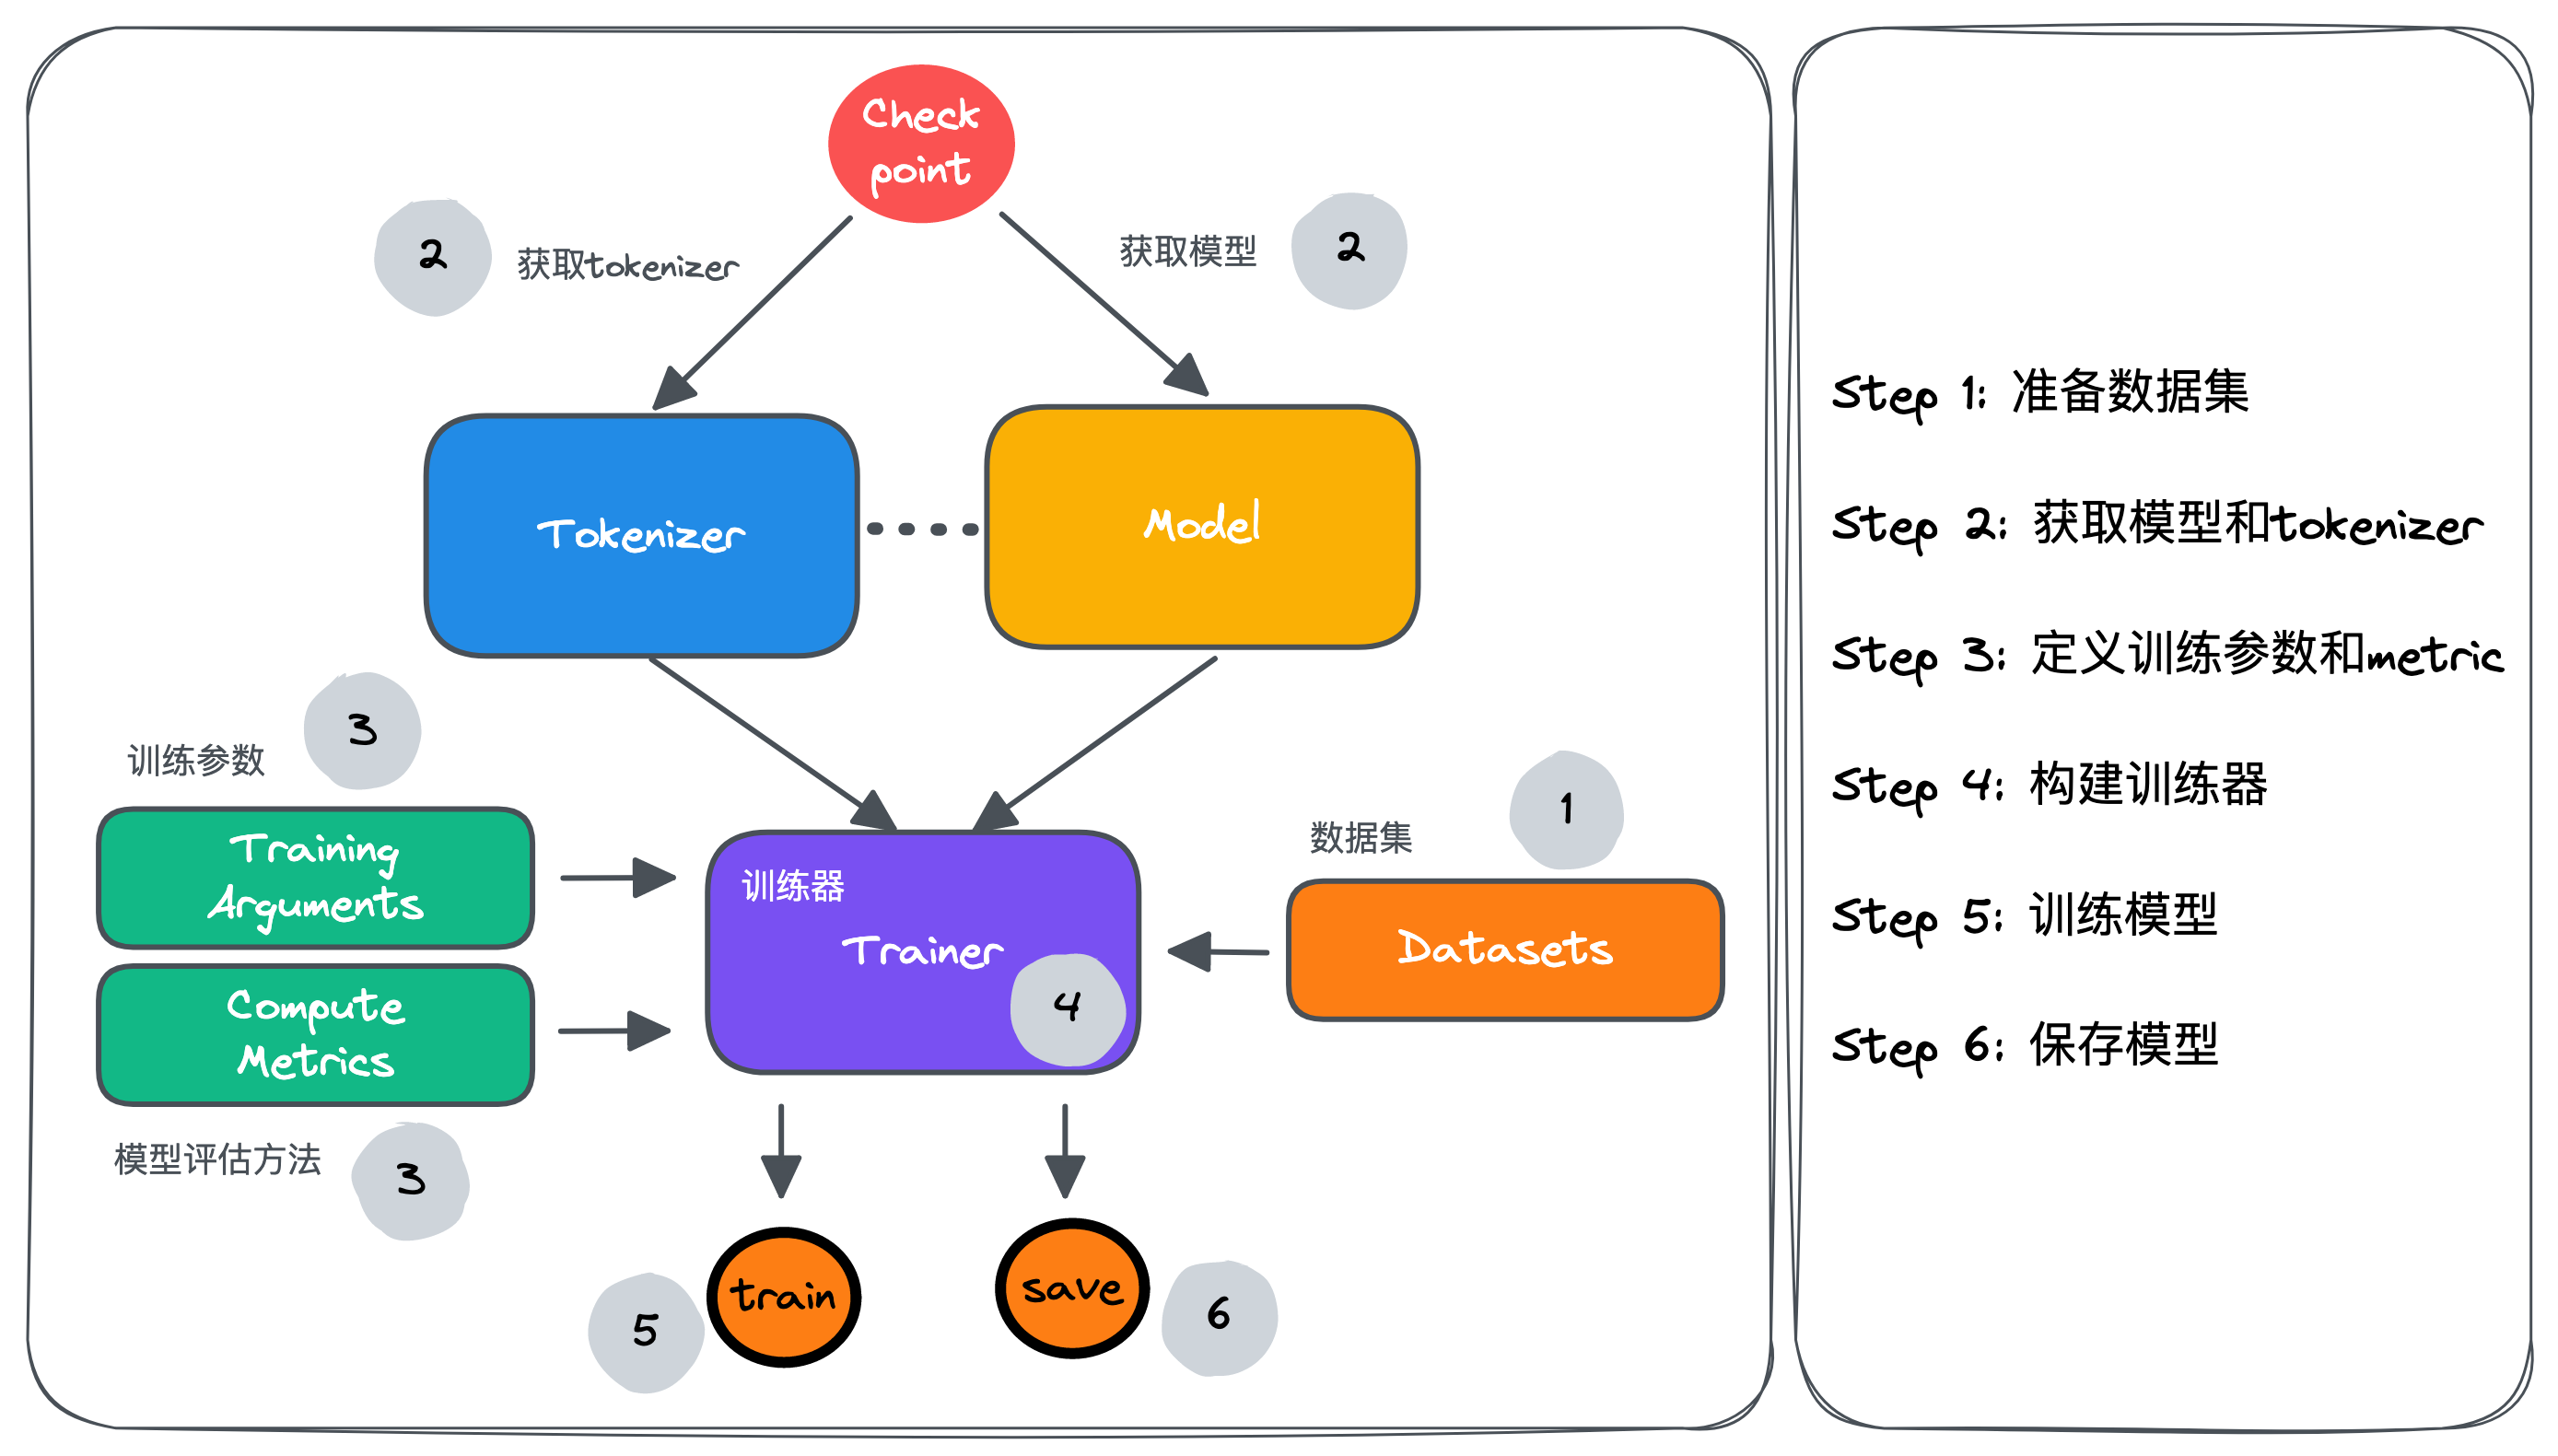

In [12]:
from IPython.display import clear_output

!pip install transformers datasets

clear_output()

## Step 1: Prepare dataset

In [13]:
from datasets import load_dataset
import numpy as np

raw_datasets = load_dataset("glue","sst2")

clear_output()

print("Dataset Info:")
print(raw_datasets)

Dataset Info:
DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})


## Step 2: Get model and tokenizer

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [15]:
checkpoint = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels = 2)

def tokenize_fn(batch):
    return tokenizer(batch['sentence'], truncation = True)

tokenized_datasets = raw_datasets.map(tokenize_fn, batched = True)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.25.1",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

  0%|          | 0/1 [00:00<?, ?ba/s]

## Step 3: Train args and metrics

In [16]:
from transformers import TrainingArguments
from datasets import load_metric

train_args = TrainingArguments(
    "saved_model_path",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    num_train_epochs = 1
)

metric = load_metric("glue","sst2")


def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis = -1)
    return metric.compute(predictions = predictions, references = labels)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


## Step 4: Trainer

In [17]:
from transformers import Trainer

trainer = Trainer(
    model = model,
    tokenizer = tokenizer,
    args = train_args,
    compute_metrics = compute_metrics,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['validation']
)

## Step 5: Train

In [18]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: idx, sentence. If idx, sentence are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 67349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8419
  Number of trainable parameters = 66955010
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` m

Epoch,Training Loss,Validation Loss,Accuracy
1,0.192100,0.373769,0.896789


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: idx, sentence. If idx, sentence are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 872
  Batch size = 8
Saving model checkpoint to saved_model_path/checkpoint-8419
Configuration saved in saved_model_path/checkpoint-8419/config.json
Model weights saved in saved_model_path/checkpoint-8419/pytorch_model.bin
tokenizer config file saved in saved_model_path/checkpoint-8419/tokenizer_config.json
Special tokens file saved in saved_model_path/checkpoint-8419/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=8419, training_loss=0.2648333146122122, metrics={'train_runtime': 286.3784, 'train_samples_per_second': 235.175, 'train_steps_per_second': 29.398, 'total_flos': 518400815624736.0, 'train_loss': 0.2648333146122122, 'epoch': 1.0})

## 6. Save Model

In [20]:
trainer.save_model('trained_model')

Saving model checkpoint to trained_model
Configuration saved in trained_model/config.json
Model weights saved in trained_model/pytorch_model.bin
tokenizer config file saved in trained_model/tokenizer_config.json
Special tokens file saved in trained_model/special_tokens_map.json


In [22]:
!ls -a trained_model

.   config.json        special_tokens_map.json	tokenizer.json	   vocab.txt
..  pytorch_model.bin  tokenizer_config.json	training_args.bin


## 7. Load Model

In [25]:
from transformers import pipeline

newmodel = pipeline("text-classification", model = 'trained_model', device = 0)

loading configuration file trained_model/config.json
Model config DistilBertConfig {
  "_name_or_path": "trained_model",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "vocab_size": 30522
}

loading configuration file trained_model/config.json
Model config DistilBertConfig {
  "_name_or_path": "trained_model",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_r

In [26]:
newmodel("This movice is great")

[{'label': 'LABEL_1', 'score': 0.9988204836845398}]

In [27]:
newmodel("This movie sucks")

[{'label': 'LABEL_0', 'score': 0.9869915246963501}]